<a href="https://colab.research.google.com/github/taegukang35/ML-study/blob/main/LIME_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from skimage.util import montage as montage2d
from sklearn.datasets import fetch_olivetti_faces

In [20]:
faces = fetch_olivetti_faces()

X_vec = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1,64,64))],0)
y_vec =  faces.target.astype(np.uint8)

(-0.5, 1279.5, 1279.5, -0.5)

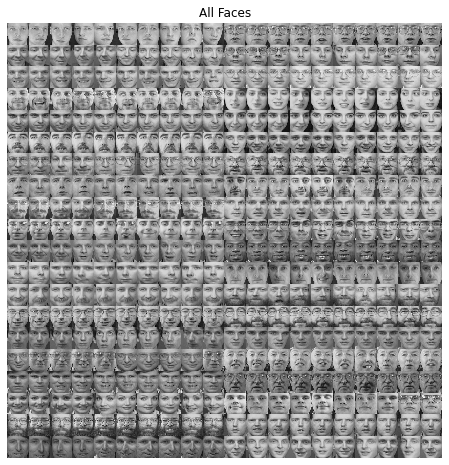

In [21]:
fig,ax1 = plt.subplots(1,1,figsize=(8,8))
ax1.imshow(montage2d(X_vec[:,:,:,0]),cmap='gray',interpolation='none')
ax1.set_title('All Faces')
ax1.axis('off')

In [22]:
y_vec

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

(-0.5, 63.5, 63.5, -0.5)

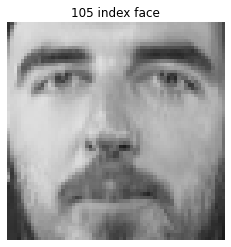

In [23]:
index = 105
plt.imshow(X_vec[index],cmap='gray')
plt.title('{} index face'.format(index))
plt.axis('off')

In [24]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_vec,y_vec,train_size=0.70)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier

class PipeStep(object):
    def __init__(self,step_func):
        self.__step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self.__step_func(X)

In [26]:
# (400x64x64x3) 데이터를 흑백으로 바꿈-> RGB 3채널을 1채널로 합산 (400x64x64x1)
makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
# 64x64 크기의 이미지를 한 줄로 펼쳐준다 64x64 = 4096 (MLP 적용하기 위함)
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])
simple_pipeline = Pipeline([
                            ('Make Gray',makegray_step),
                            ('Flatten Image',flatten_step),
                            ('Normalize',Normalizer()),
                            ('MLP',MLPClassifier(
                                activation='relu',
                                alpha = 1e-7,
                                epsilon = 1e-6,
                                hidden_layer_sizes=(800,120),
                                random_state=1))
                            ])

In [27]:
simple_pipeline.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7fcb314a0350>),
                ('Flatten Image', <__main__.PipeStep object at 0x7fcb314a01d0>),
                ('Normalize', Normalizer()),
                ('MLP',
                 MLPClassifier(alpha=1e-07, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               random_state=1))])

In [28]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test,y_pred=pipe_pred_test))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       0.50      0.33      0.40         3
           4       1.00      1.00      1.00         2
           5       0.75      1.00      0.86         3
           6       1.00      0.67      0.80         3
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       0.75      0.75      0.75         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         3
          15       1.00      0.67      0.80         3
          16       0.00      0.00      0.00         1
          17       0.83    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
!pip install lime

In [31]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

# 이미지 분할 알고리즘: quickshift, slick, felzenszwalb
segmenter = SegmentationAlgorithm('slic',n_segments =100,compactness=1,sigma=1)

In [32]:
olivetti_test_index = 0
exp = explainer.explain_instance(X_test[olivetti_test_index],
                                 classifier_fn=simple_pipeline.predict_proba,
                                 top_labels = 6,
                                 num_samples = 1000,
                                 segmentation_fn=segmenter)

/usr/local/lib/python3.7/dist-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Show mask only')

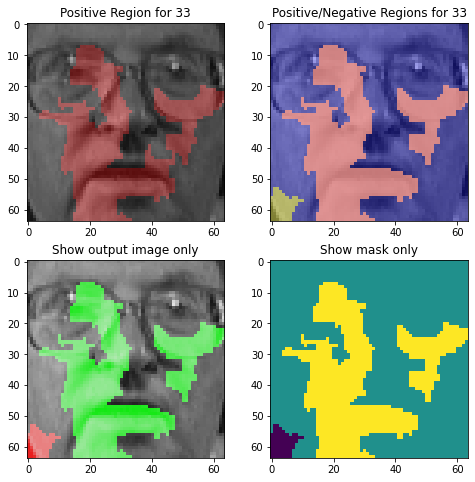

In [33]:
from skimage.color import label2rgb
# 캔버스 설정
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

# 예측에 도움이 되는 세그먼트 출력 
temp,mask = exp.get_image_and_mask(y_test[olivetti_test_index],positive_only=True,num_features=8,hide_rest=False)
ax1.imshow(label2rgb(mask,temp,bg_label=0),interpolation='nearest')
ax1.set_title('Positive Region for {}'.format(y_test[olivetti_test_index]))

# 모든 세그먼트 출력
temp,mask = exp.get_image_and_mask(y_test[olivetti_test_index],positive_only=False,num_features=8,hide_rest=False)
ax2.imshow(label2rgb(4-mask,temp,bg_label=0),interpolation='nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[olivetti_test_index]))

# 이미지만 출력
ax3.imshow(temp,interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask,interpolation='nearest')
ax4.set_title('Show mask only')